#LSTM NN con MNIST

*Long-Short Term Memory* neural network sviluppata in TensorFlow versione 1.x, su database MNIST.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
from tensorflow import keras as ks

#tf.reset_default_graph()

#RNN Cells and additional RNN operations.
#contrib è un modulo "sperimentale" in TF 1.x; aggiunto in TF 2.x
#from tensorflow.contrib import rnn
#Preferisco utilizzare keras (come built-in in TensorFlow) che le strutture in tf

print(tf.__version__)

1.15.2


In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

#Per interoperabilità di Python 2/3
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

import time

print("Done")

Done


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Definizione altri metodi
Definisco qui i metodi che mi permettono di disegnare grafi e di analizzare il tempo di addestramento.

In [4]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

print("Done")

Done


In [5]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

print("Done")

Done


##Import dei dati
Importo il database MNIST, e ne controllo la forma.

In [6]:
#Import del database MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Struttura dati nel database
print("Numero elementi e dimensione immagini in train set: " + str(train_images.shape))
print("Numero elementi e dimensione immagini in test set: " + str(test_images.shape))
print("Numero elementi label in train set: " + str(len(train_labels)))
print("Numero elementi label in test set: " + str(len(test_labels)))
print("Tipo di struttura del train set: " + str(type(train_images)) + ", composto da " + str(type(train_images[0])))
print("Tipo di struttura del label set: " + str(type(train_labels)) + ", composto da " + str(type(train_labels[0])))
print("Le etichette sono interi; valore più piccolo: " + str(np.amin(train_labels)) + ", valore più grande: " + str(np.amax(train_labels)))

Numero elementi e dimensione immagini in train set: (60000, 28, 28)
Numero elementi e dimensione immagini in test set: (10000, 28, 28)
Numero elementi label in train set: 60000
Numero elementi label in test set: 10000
Tipo di struttura del train set: <class 'numpy.ndarray'>, composto da <class 'numpy.ndarray'>
Tipo di struttura del label set: <class 'numpy.ndarray'>, composto da <class 'numpy.uint8'>
Le etichette sono interi; valore più piccolo: 0, valore più grande: 9


##Preprocessing dei dati

Scalo le immagini in range 0-1.

Ho bisogno che i dati, ossia le immagini, siano raffigurate come array in numpy per poter essere analizzate dalla NN; MNIST le fornisce già nel formato numpy.

Altrimenti:


```
x_train, y_train = np.array(x_train), np.array(y_train)
```

Dal database tf.keras.datasets.mnist, il formato è np.ndarray.


In [7]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


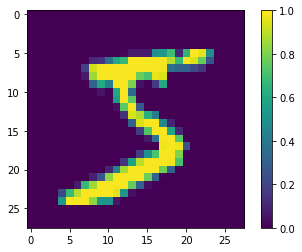

In [8]:
#Controllo lo scaling dei dati
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
train_images.shape

(60000, 28, 28)

#Struttura LSTM

[Struttura LSTM spiegata](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

[Altro link che ne spiega la struttura](https://github.com/MohammadFneish7/Keras_LSTM_Diagram).

Comunemente una LSTM unit è composta da una cella, da un input gate, un output gate e un forget gate (le GRU non hanno l'output gate).
Le LSTM neural network sono un tipo di recurrent neural network che non soffrono (o ne soffrono molto limitatamente) del [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
Rispetto ad altri modelli, come hidden Markov model, le LSTM sono meno "sensibili" alla "gap length", ossia correlazioni tra distanti dati analizzati; negli hidden Markov models, il next value è influenzato solo dal value attuale, e il modello fatica a trovare le eventuali correlazioni con i dati analizzati precedentemente, problema che le LSTM risolvono.
Le LSTM richiedono 3D vectors, che contengono anche il tempo come dimensione, quindi una rete LSTM si aspetta input 3-dimensionali della forma `[samples, time steps, features]`.

Per classificare le immagini usando una recurrent neural network, consideriamo ogni riga come sequenza di pixels (cosa che è).
Siccome le immagini MNIST sono di dimensione 28*28px, gestiremo 28 sequenze da 28 time steps per ogni sample.

Ossia, l'immagine è una matrice di 28*28 pixels, utilizzo come analisi nel tempo, cioè time steps, una riga, pertanto "ricordo" le righe precedenti; leggerò una immagine intera dopo 28 time steps.

Se forniamo *batch_size* immagini alla volta, ogni time step (quindi 28 nel nostro caso) riceverà le corrispondenti righe delle *n* immagini (con *n* grandezza batch).

Ho quindi 28 LSTM cells, una per time step, che memorizzano lo "*stato*", ossia la riga al tempo *n*, che è la riga *n-esima*. La riga è poi analizzata come sequenza di 28 features; al termine avrò analizzato 28*28 pixels, ossia tutta l'immagine.

Al layer LSTM posso passare in input tutte le immagini, o meglio un batch di immagini; ogni immagine nel batch viene analizzato da un neurone nel layer, pertanto è ottimale avere `batch_size == number_of_cells`.

![Hochreiter, Sepp, and Jürgen Schmidhuber. "Long short-term memory." Neural computation 9.8 (1997): 1735-1780](https://qph.fs.quoracdn.net/main-qimg-3714ad776948339181a2484495a6e428)
Nell'immagine, *forget gate* non presente.

![Rappresentazione di una LSTM](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Peephole_Long_Short-Term_Memory.svg/1024px-Peephole_Long_Short-Term_Memory.svg.png)

Posso fare il reshape dell'np.ndarray, oppure indicare l'input shape nella costruzione del modello.

La struttura da passare alla LSTM, è `[samples, time steps, features]`.
Per sample x, voglio 28 time steps, e seleziono 28 features, ossia "analizzo" 28 features, cioè i pixels nella riga.

##LSTM Cell
![LSTM Cell](https://user-images.githubusercontent.com/10358317/44312843-34a8bc80-a407-11e8-96c3-cc2bc07f1500.png)

##CuDNN

CuDNN è una libreria di funzioni utili allo sviluppo di reti neurali che sono ottimizzate per sfruttare la GPU.

##Costanti e parametri

In [10]:
#Costanti
batch_size = 512
time_steps = 28
n_features = 28
n_classes = 10

#Unit in first layer
num_units1 = batch_size
#Unit in second layer
num_units2 = (int)(num_units1 / 2)

#unused
num_batches = int(len(train_labels) / batch_size)

#Activation dell'ultimo layer, dense
act = 'softmax'

#Optimizer
opt = 'adam'
#opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

print("Done")

Done


In [11]:
# see how data looks like
print('Check the dimensions')
print('train_images.shape: ' + str(train_images.shape))
print('train_labels.shape: ' + str(train_labels.shape))
print('test_images.shape: ' + str(test_images.shape))
print('test_labels.shape: ' + str(test_labels.shape))

Check the dimensions
train_images.shape: (60000, 28, 28)
train_labels.shape: (60000,)
test_images.shape: (10000, 28, 28)
test_labels.shape: (10000,)


##Preprocessing dati per LSTM

In [12]:
train_images = train_images.reshape(-1, time_steps, n_features)

test_images = test_images.reshape(-1, time_steps, n_features)

print("Done")

Done


##Modello 1
Modello iniziale, funziona; con 10 epoche (troppe) l'accuracy era oltre il 98%.

In [13]:
"""

modelLSTM = ks.Sequential()

modelLSTM.add(LSTM(num_units, input_shape=(time_steps, n_features)))
modelLSTM.add(Dense(n_classes, activation=act))

modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

modelLSTM.summary()

"""

"\n\nmodelLSTM = ks.Sequential()\n\nmodelLSTM.add(LSTM(num_units, input_shape=(time_steps, n_features)))\nmodelLSTM.add(Dense(n_classes, activation=act))\n\nmodelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])\n\nmodelLSTM.summary()\n\n"

##Impostazioni del layer LSTM

Una rete LSTM si aspetta input 3-dimensionali della forma `[samples, time steps, features]`.

*activation*: il valore di default è tanh.

*return_sequences*: è importante metterlo a true se vengono utilizzati due layer LSTM in successione.

*stateful*: true/false, indica se è una LSTM stateful o stateless, ossia se i dati processati dal layer sono indipendenti o dipendono dai dati analizzati prima/dopo (in quel caso si parla di stateful).

*dropout*: la logica del dropout è quella di aggiungere rumore ai neuroni in ordine di non essere dipendenti da qualche neurone specifico. Aggiungendo dropout alle celle LSTM, c'è una possibilità (più o meno grande) che il neurone dimentichi qualcosa, e che sia qualcosa che serva. Di conseguenza, è meglio utilizzare il dropout con dense layers dopo LSTM layers in CNN.

##Impostazioni aggiuntive
Posso andare ad aggiustare varie impostazioni della LSTMCell, ossia l'unità all'interno del layer LSTM, che maneggia un singolo time step.

In generale, una LSTM è una RNN composta da LSTMCell.

##Build

In [14]:
modelLSTM = ks.Sequential()

#Default activation in LSTM is tanh
modelLSTM.add(LSTM(num_units1, input_shape=(time_steps, n_features), activation='relu', return_sequences='true'))
modelLSTM.add(LSTM(num_units2, activation='relu'))
modelLSTM.add(Dense(n_classes, activation=act))

print("Done")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Done


##Compile

In [15]:
modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 512)           1107968   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 1,897,994
Trainable params: 1,897,994
Non-trainable params: 0
_________________________________________________________________


##Fit del modello

Utilizzando la CPU, il tempo utilizzato con questo modello è superiore ai 20 minuti; utilizzo quindi la GPU.

In [16]:
#modelLSTM.metrics_names
#history_dict = hist.history
#print(history_dict.keys())

'''
acc è l'accuracy;
val_acc è l'accuracy sul validation set.
Idem per loss e val_loss.
'''

"\nacc è l'accuracy;\nval_acc è l'accuracy sul validation set.\nIdem per loss e val_loss.\n"

In [28]:
#Batch size should be (at most) the same number of hidden cells
time_callback = TimeHistory()
hist = modelLSTM.fit(train_images, train_labels, 
                     batch_size = batch_size,
                     validation_data=(test_images, test_labels), 
                     epochs=2,
                     callbacks=[time_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 221us/sample - loss: 0.2130 - acc: 0.9317 - val_loss: 0.1341 - val_acc: 0.9571
Epoch 2/2
60000/60000 [==============================] - 13s 225us/sample - loss: 0.1158 - acc: 0.9636 - val_loss: 0.0763 - val_acc: 0.9761


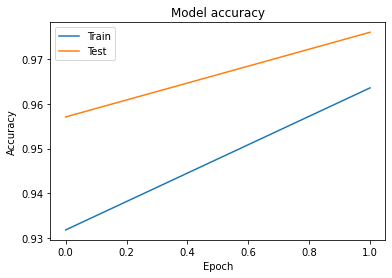

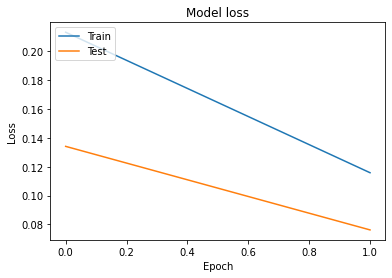

Time per epoch: [13.254263401031494, 13.471528053283691]
Total time: 26.725791454315186


In [29]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [30]:
#Necessito di un array con tutte le labels
classes=[0,1,2,3,4,5,6,7,8,9]

test_predictions = modelLSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

[[ 971    0    0    0    1    1    0    1    5    1]
 [   0 1126    1    0    0    0    3    1    3    1]
 [   2    2 1012    7    1    0    1    2    5    0]
 [   0    2    4  989    0    5    0    3    4    3]
 [   1    0    0    0  948    0    1    2    2   28]
 [   1    2    2    8    0  865    1    2    5    6]
 [   5    2    0    0    2    3  938    0    8    0]
 [   0    6    9    3    0    0    0  987    2   21]
 [   5    0    3    3    1    3    1    0  954    4]
 [   3    1    0    5    7    2    0    4   16  971]]


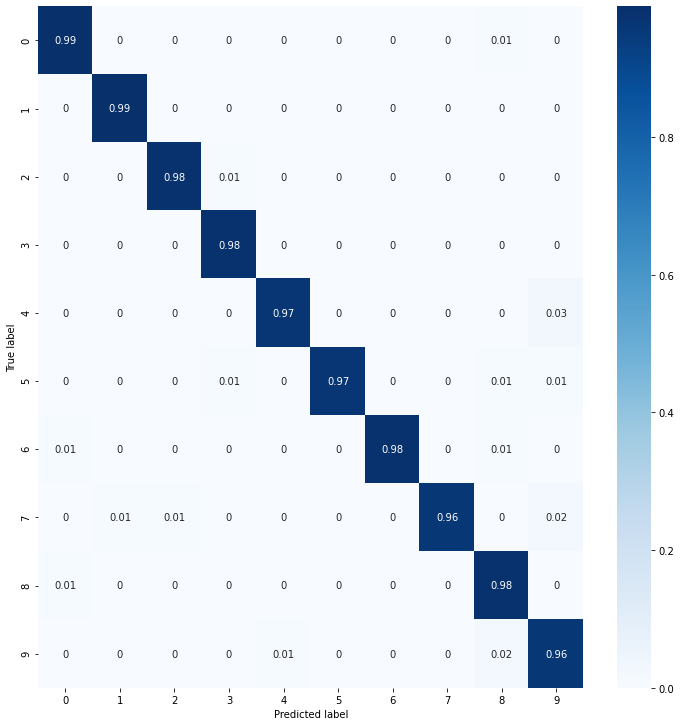

In [31]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##Test predizioni
Predico un piccolo sottoinsieme.

In [32]:
predictions = modelLSTM.predict(test_images)

print("Done")

Done


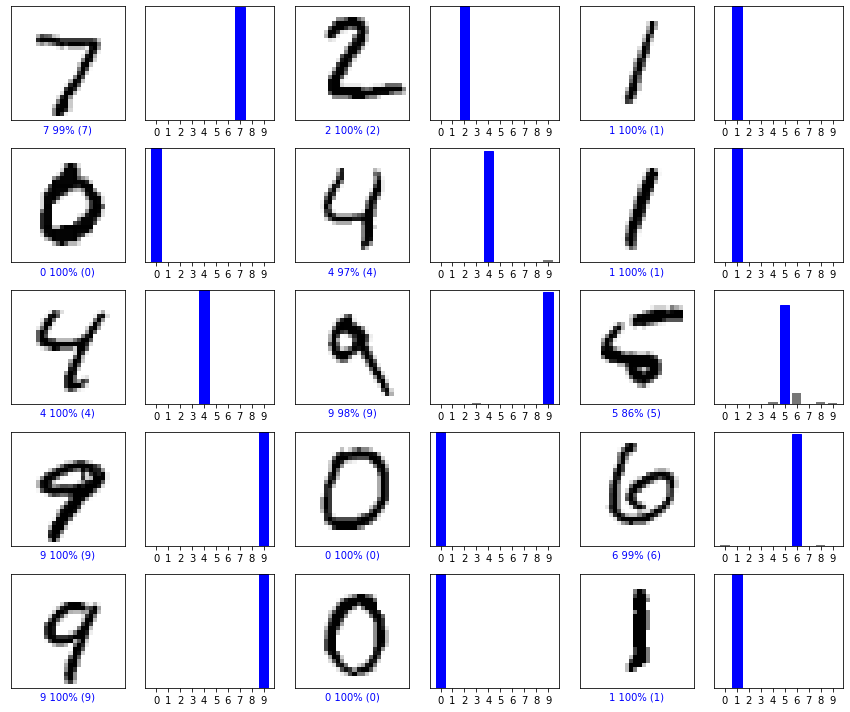

In [33]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

#Test visualization of activation

Preso da [qui](https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0),

In [34]:
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [35]:
layer_outputs = [layer.output for layer in modelLSTM.layers[:3]] 
# Extracts the outputs of the top 3 layers

In [36]:
layer_outputs

[<tf.Tensor 'lstm/transpose_1:0' shape=(?, 28, 512) dtype=float32>,
 <tf.Tensor 'lstm_1/strided_slice_7:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dense/Softmax:0' shape=(?, 10) dtype=float32>]

In [38]:
activation_model = tf.keras.models.Model(inputs=modelLSTM.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [40]:
activations = activation_model.predict(test_images) 
# Returns a list of five Numpy arrays: one array per layer activation

In [73]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(10000, 28, 512)


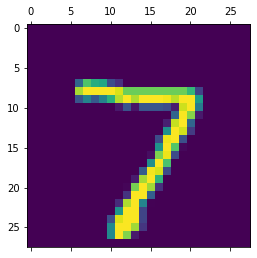

In [115]:
plt.matshow(test_images[0], cmap='viridis')

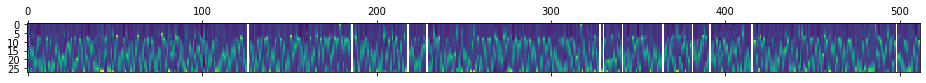

In [85]:
plt.matshow(first_layer_activation[0, :, :], cmap='viridis')